In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as vF
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import v2
from torchvision.models import mobilenet_v2, mobilenet_v3_large, vgg19, vgg16, resnet50, resnet18
from timm.models.swin_transformer import SwinTransformer
from sklearn.linear_model import LinearRegression
import kagglehub
import numpy as np
import os
from PIL import Image
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
from losses import SupConLoss
from torch.nn import TripletMarginLoss
import random
from Utils import GetDataset

c:\Users\tsope\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Training

In [5]:
# Hyperparameters
batch_size  = 128
epochs      = 150
lr          = 1e-4
split_ratio = 0.9   # %
device      = "cuda:0"
features_dim = 64

dataset = GetDataset(data_augmentation=False)

# Get the total size of the dataset
dataset_size = len(dataset)

# Calculate sizes for training and validation splits
train_size = int(split_ratio * dataset_size)
val_size = dataset_size - train_size

# Perform the split
generator1 = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=generator1)

# Create DataLoaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True )
val_loader   = DataLoader(val_dataset  , batch_size=batch_size, shuffle=False)

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(126*126, 2048),
    nn.ReLU(),
    nn.Linear(2048, 2048),
    nn.ReLU(),
    nn.Linear(2048, 2048),
    nn.ReLU(),
    nn.Linear(2048, 2048),
    nn.ReLU(),
    nn.Linear(2048, 2048),
    nn.ReLU(),
    nn.Linear(2048, 1024),
    nn.ReLU(),
    nn.Linear(1024, 1024),
    nn.ReLU(),
    nn.Linear(1024, 64),
    nn.ReLU(),
    nn.Linear(64, 1)
).to(device)

optimizer   = torch.optim.Adam(model.parameters(), lr=lr,)
lossfn      = nn.MSELoss()

training_losses = []
validation_losses = []
r2s = []
for epoch in range(epochs):
  model.train()
  print(f'########################################')
  print(f'Epoch: {epoch+1}')
  losses = 0
  count  = 0
  for images, temperatures in train_loader:
    N = images.shape[0]
    V = images.shape[1]
    images = images.to(device)
    temperatures = temperatures.to(device).squeeze()
    ##
    ##
    ##
    pred  = model(images).squeeze()
    loss  = lossfn(pred, temperatures)

    # Backpropagation and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses += loss.cpu().detach().numpy()
    count  += 1

    print(f'*', end='')
  print('\n')
  print(f'MSE : {losses / count}')
  print(f'RMSE: {np.sqrt(losses / count)}')
  training_losses.append(losses / count)

  with torch.no_grad():
    losses = 0
    count  = 0
    y_pred = []
    y_test = []
    for images, temperatures in val_loader:
      N = images.shape[0]
      V = images.shape[1]
      images = images.to(device)
      temperatures = temperatures.to(device).squeeze()
      pred = model(images).squeeze()
      loss = lossfn(pred, temperatures)
      losses += loss.cpu().detach().numpy()
      count += 1

      y_pred.append(pred.squeeze().cpu().detach().numpy())
      y_test.append(temperatures.squeeze().cpu().detach().numpy())
      
  y_pred = np.array(y_pred).flatten()
  y_test = np.array(y_test).flatten()

  r2 = r2_score(y_test, y_pred)
  print(f'Validation: MSE : {losses / count}')
  print(f'Validation: RMSE: {np.sqrt(losses / count)}')
  print(f'Validation R2: {r2}')
  validation_losses.append(losses / count)
  r2s.append(r2)

Path to dataset files: C:\Users\tsope\.cache\kagglehub\datasets\juanda220485\synthetic-dataset-of-speckle-images\versions\1
########################################
Epoch: 1
*****

MSE : 4869.35419921875
RMSE: 69.78075808716004
Validation: MSE : 4875.60205078125
Validation: RMSE: 69.8255114609356
Validation R2: -2.8059916496276855
########################################
Epoch: 2
*****

MSE : 4659.37255859375
RMSE: 68.25959682413712
Validation: MSE : 4733.13134765625
Validation: RMSE: 68.79775685046897
Validation R2: -2.6947765350341797
########################################
Epoch: 3
*****

MSE : 4283.194091796875
RMSE: 65.44611594126022
Validation: MSE : 3468.9462890625
Validation: RMSE: 58.897761324709954
Validation R2: -1.7079284191131592
########################################
Epoch: 4
*****

MSE : 2229.5552001953124
RMSE: 47.21816599779488
Validation: MSE : 2217.837890625
Validation: RMSE: 47.09392626045316
Validation R2: -0.7312884330749512
####################################

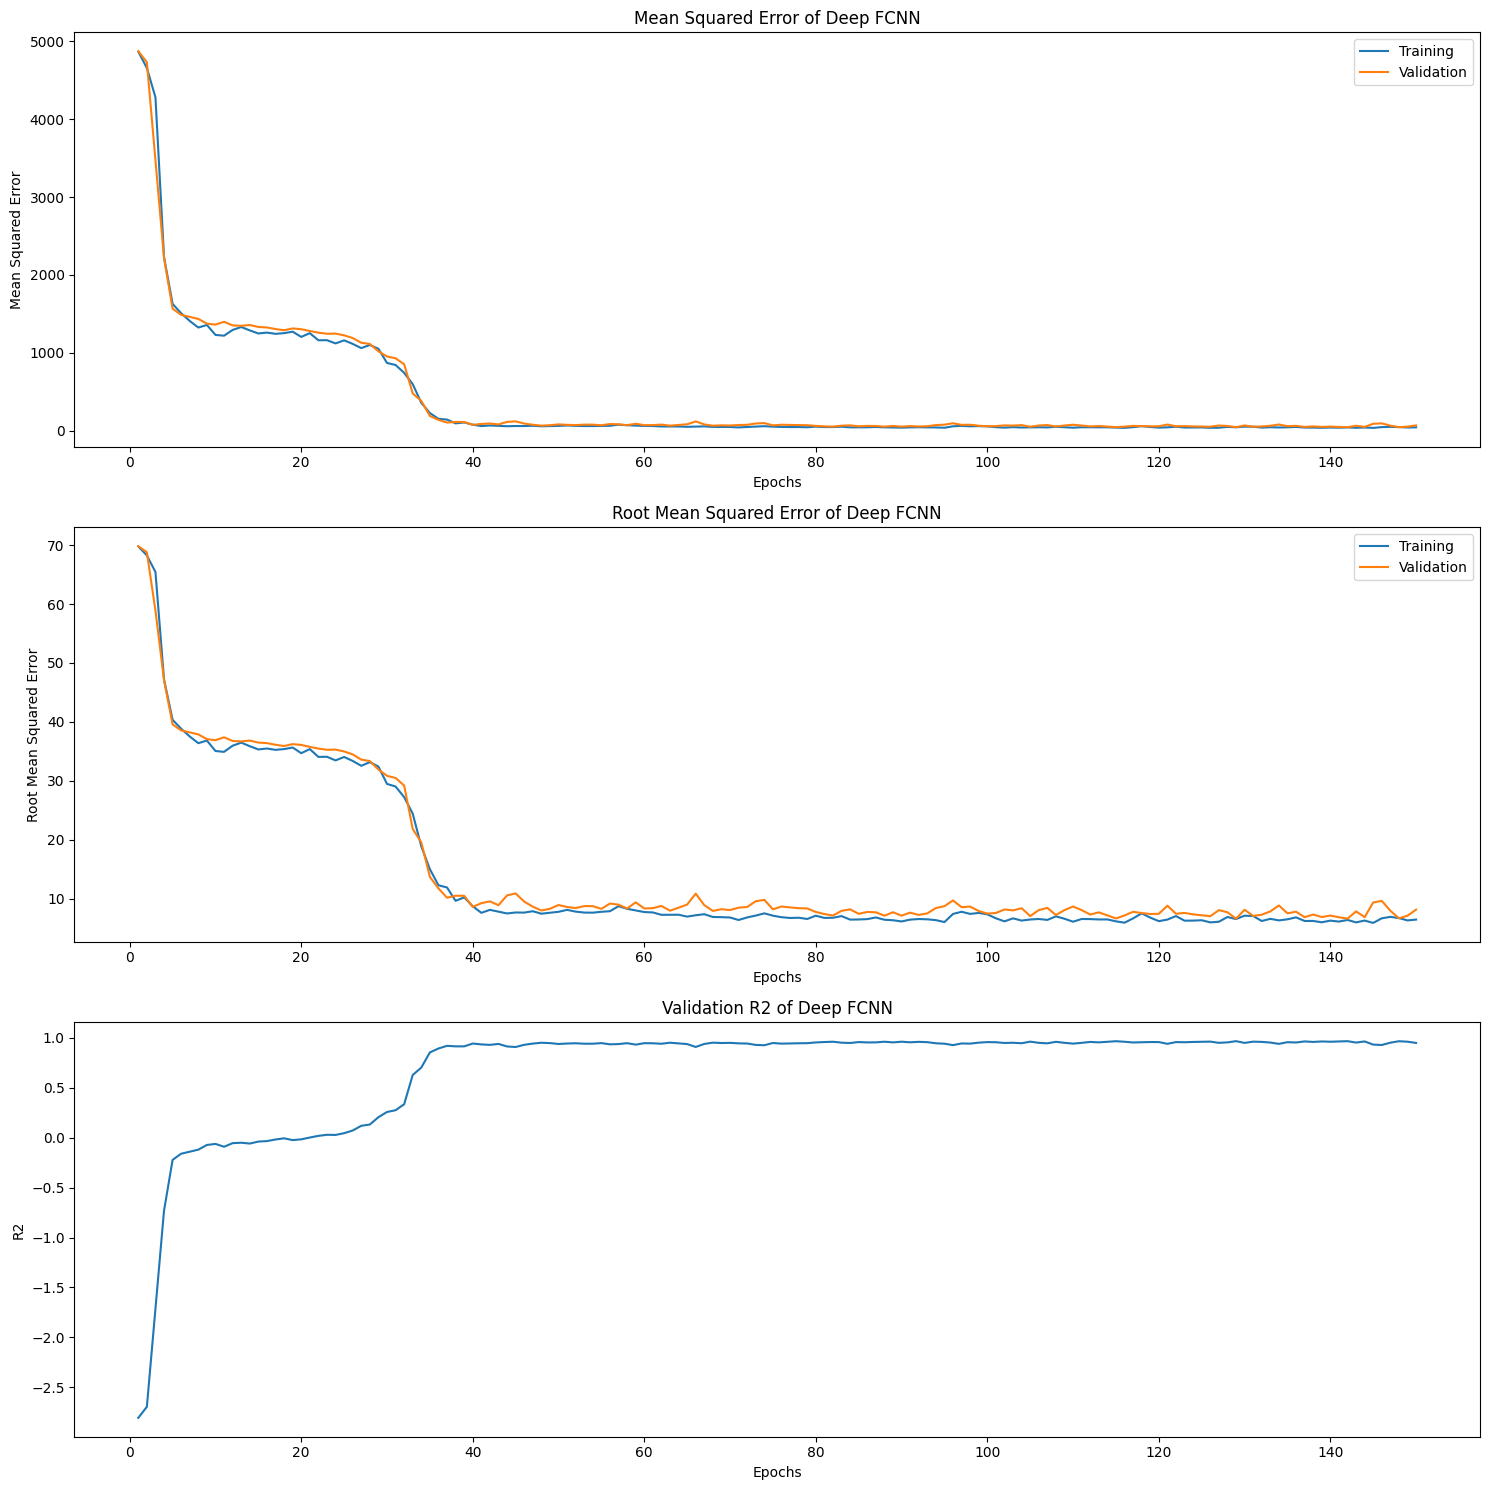

In [11]:
num_epochs_r = np.arange(1, 151)
plt.figure(figsize=[15, 15])
plt.subplot(3, 1, 1)
plt.plot(num_epochs_r, np.array(training_losses), num_epochs_r, np.array(validation_losses))
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error")
plt.title("Mean Squared Error of Deep FCNN")
plt.legend(['Training', 'Validation'])

plt.subplot(3, 1, 2)
plt.plot(num_epochs_r, np.sqrt(training_losses), num_epochs_r, np.sqrt(validation_losses))
plt.xlabel("Epochs")
plt.ylabel("Root Mean Squared Error")
plt.title("Root Mean Squared Error of Deep FCNN")
plt.legend(['Training', 'Validation'])

plt.subplot(3, 1, 3)
plt.plot(num_epochs_r, np.array(r2s))
plt.xlabel("Epochs")
plt.ylabel("R2")
plt.title("Validation R2 of Deep FCNN")

plt.tight_layout()
plt.show()

In [10]:
torch.save(model, 'deep_fcnn.pth')

## ~52 million parameters